## EOG Signal Analysis: From Acquisition to Processing

### Introduction to EOG
Electrooculography (EOG) measures electrical signals produced by our Eyes. This notebook will guide you through:

- Collecting eye signals in real-time
- Understanding raw EOG data
- Cleaning up the signals
- Detecting Blinks

### Getting Ready
First, we need some Python libraries. If you haven't installed them yet, run this command in your terminal:
```
pip install -r requirements.txt
```
Then, these libraries can be imported.

In [69]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
# Import necessary libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
from helper.chords_usb import Chords_USB
from IPython.display import display, clear_output
import pandas as pd
import scipy.signal as signal
from pyqtgraph.Qt import QtWidgets, QtCore
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
from PyQt5 import QtWidgets, QtCore
from scipy import signal
import time

#### Here, the data streaming starts.

In [71]:
# This cell initializes the Chords_USB client, checks for compatible hardware, and starts the data streaming process.
client = Chords_USB()

if not client.detect_hardware():
    raise Exception("Could not detect compatible hardware")

client.send_command('START')
print("Streaming started...")

Trying COM25 at 230400...
NPG-LITE detected at COM25 with baudrate 230400
Streaming started...


### Getting Connected
#### Setting Up the Hardware
We'll connect to our device through a USB cable. Some devices can also connect wirelessly.

**Pro Tip:** For better signals:
1. Clean the skin with alcohol swab.

For more information checkout [skin prepration guide section](https://docs.upsidedownlabs.tech/guides/usage-guides/skin-preparation/index.htm) on documentation site.

2. Place electrodes like this:

<img src="assets/eog-h.jpg" alt="Electrode Placement" width="400">

<img src="assets/eog-v.jpg" alt="Electrode Placement" width="400">

### Collecting Eye Signals
Let's record 15 seconds of eye signals! During this time:
- Try sitting away from DC Appliances.

**Settings:**
- Recording time: 15 seconds
- Sampling rate: 250/500 Hz depending on the development board
- Smooth animation: 5 updates per second

You'll see a live graph of your eye's electrical activity

### Raw EOG Signal
The first graph shows unfiltered eye signals - it will look wiggly because of natural electrical noise.

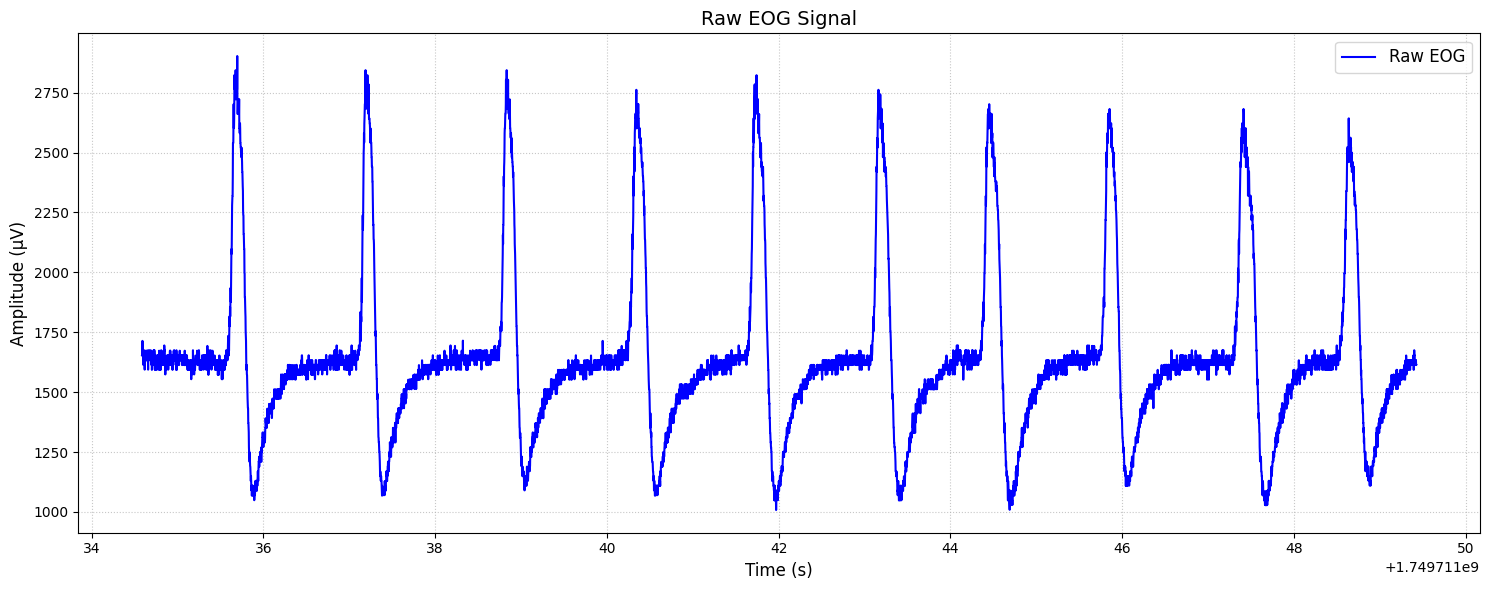

In [72]:
# This cell configures real-time EOG data acquisition, sets up a live plotting window, and continuously updates the display with incoming data for a specified duration.
duration = 15             # Duration for real-time data collection
sampling_rate = client.supported_boards[client.board]["sampling_rate"]
samples_per_update = 100  # Number of samples to add each update
frames_per_second = 5     # 200ms (5 FPS)
update_interval = 1 / frames_per_second  # Update interval in seconds
window_seconds = 15       # seconds to display
window_samples = int(window_seconds * sampling_rate)
time_data = np.array([])
eog_data = np.array([])

# Set up interactive mode for window display only
%matplotlib qt5
plt.ion()

fig_window, ax_window = plt.subplots(figsize=(12, 6))    # Create figure for separate window only
fig_window.canvas.manager.window.setWindowTitle('Real-time EOG Acquisition')

win = fig_window.canvas.manager.window
win.setWindowFlags(win.windowFlags() | QtCore.Qt.WindowStaysOnTopHint)
win.show()

# Configure plot
ax_window.set_title('Real-time EOG Signal')
ax_window.set_xlabel('Time (s)')
ax_window.set_ylabel('Amplitude')
ax_window.grid(True)
ax_window.set_ylim(0, 5000)

plt.tight_layout()

line_window, = ax_window.plot([], [], 'b-')   # Create line for plot

start_time = time.time()
last_update = start_time

# Real-time acquisition loop
while time.time() - start_time < duration:
    client.read_data()
    
    if client.data is not None:
        new_samples = client.data[0, :]
        current_time = time.time()
        if current_time - last_update >= update_interval:
            samples_to_take = min(samples_per_update, len(new_samples))
            if samples_to_take > 0:
                new_eog = new_samples[-samples_to_take:]
                new_time = np.linspace(current_time - samples_to_take/sampling_rate, current_time, samples_to_take, endpoint=False)
                
                valid_mask = np.isfinite(new_eog)     # Remove any NaN or inf values
                new_eog = new_eog[valid_mask]
                new_time = new_time[valid_mask]
                
                if len(new_eog) > 0:  # Only proceed if we have valid data
                    time_data = np.concatenate((time_data, new_time))
                    eog_data = np.concatenate((eog_data, new_eog))
                    
                    valid_mask = np.isfinite(eog_data) & np.isfinite(time_data)   # Remove any NaN/inf that might have been in existing data
                    eog_data = eog_data[valid_mask]
                    time_data = time_data[valid_mask]
                    
                    cutoff_time = current_time - window_seconds
                    keep_mask = time_data >= cutoff_time
                    time_data = time_data[keep_mask]
                    eog_data = eog_data[keep_mask]
                    
                    if len(time_data) > 0 and len(eog_data) > 0:
                        relative_time = time_data - start_time
                        
                        line_window.set_data(relative_time, eog_data)
                        ax_window.set_xlim(max(0, relative_time[-1] - window_seconds), max(window_seconds, relative_time[-1]))
                        fig_window.canvas.draw()
                        fig_window.canvas.flush_events()
                
                last_update = current_time

plt.close(fig_window)
plt.ioff()

# Plot raw data
%matplotlib inline
plt.figure(figsize=(15, 6))
plt.plot(time_data, eog_data, 'b-', linewidth=1.5, label='Raw EOG')
plt.title('Raw EOG Signal', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### EOG Signal Processing - Cleaning Up the Signal
We use special filters to clean up the data:
- **Notch Filter** - Removes electrical interference (50/60Hz)
- **Low-Pass Filter** - Smooths out the signal

#### CSV File
Then, at the end the data is saved as CSV File in the csv folder with file name eog_data.

Filtered data saved as 'csv\eog_data.csv'


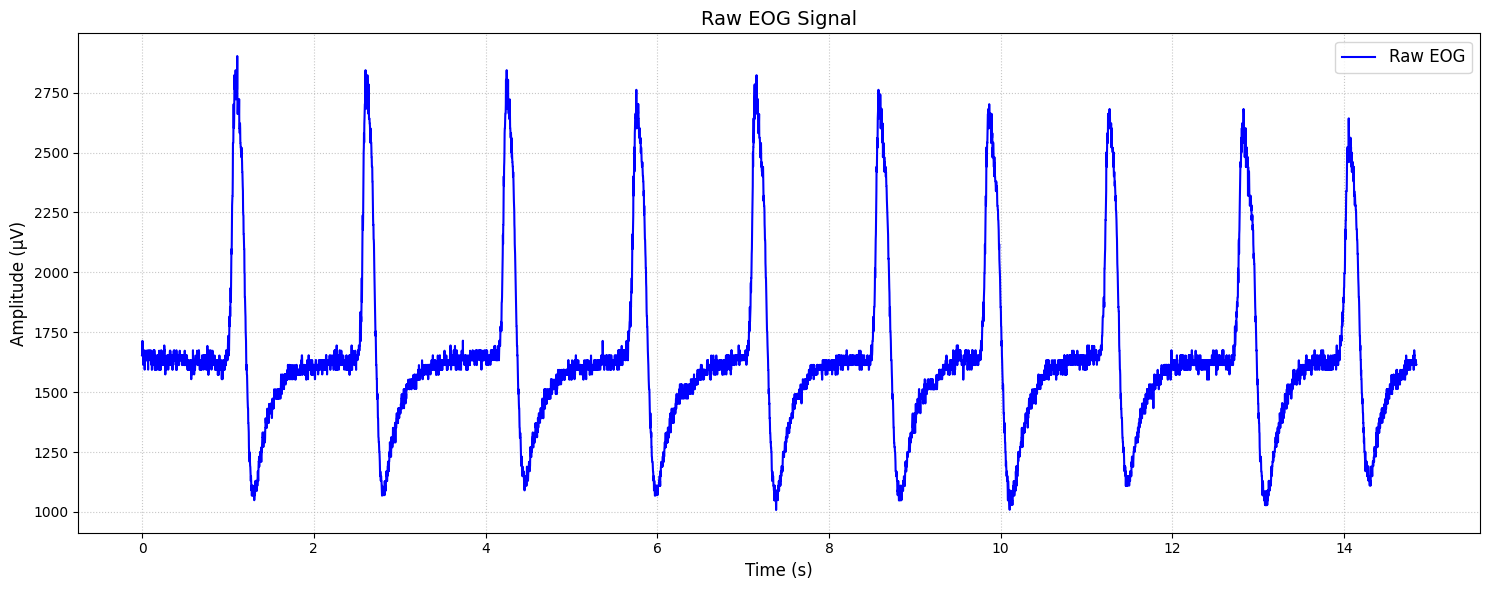

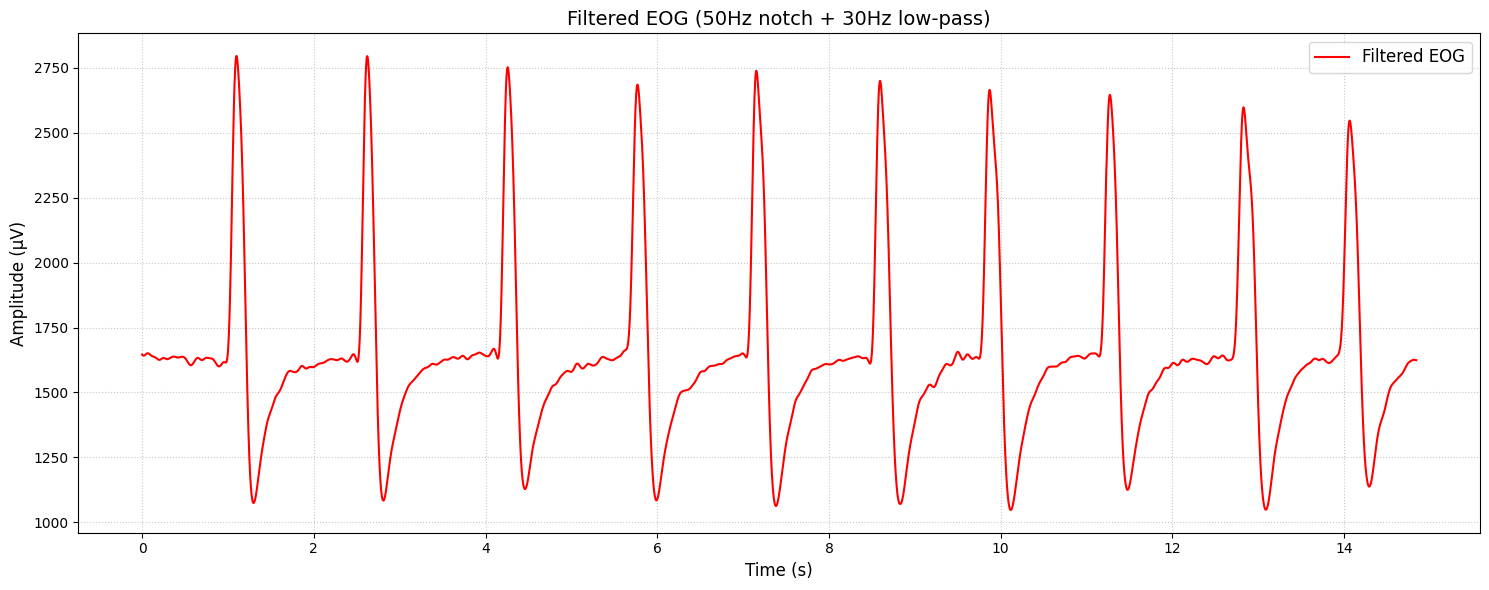

In [73]:
# This cell processes the acquired EOG data by applying notch and low-pass filters, saves the results to a CSV file, and visualizes both raw and filtered signals.
%matplotlib inline
time_axis = time_data - start_time

def notch_filter(data, fs, freq=50.0, quality_factor=30.0):
    nyq = 0.5 * fs
    freq = freq / nyq
    b, a = signal.iirnotch(freq, quality_factor)
    return signal.filtfilt(b, a, data)

def lowpass_filter(data, fs, cutoff=10.0, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, data)

# Apply filters
eog_notch = notch_filter(eog_data, sampling_rate, freq=50.0)
eog_filtered = lowpass_filter(eog_notch, sampling_rate, cutoff=10.0)

eog_df = pd.DataFrame({'Time (s)': time_axis,'Raw_EOG': eog_data,'Notch_Filtered_50Hz': eog_notch,'LowPass_Filtered_30Hz': eog_filtered})

# Save to CSV
output_folder = 'csv'
os.makedirs(output_folder, exist_ok=True)
csv_filename = os.path.join(output_folder, 'eog_data.csv')
eog_df.to_csv(csv_filename, index=False)
print(f"Filtered data saved as '{csv_filename}'")

# Plot raw signal
plt.figure(figsize=(15, 6))
plt.plot(time_axis, eog_data, 'b-', linewidth=1.5, label='Raw EOG')
plt.title('Raw EOG Signal', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot filtered signal
plt.figure(figsize=(15, 6))
plt.plot(time_axis, eog_filtered, 'r-', linewidth=1.5, label='Filtered EOG')
plt.title('Filtered EOG (50Hz notch + 30Hz low-pass)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Blink Detection
Finding Blinks
- We detect R-peaks (the tallest spikes in ECG) to calculate heart rate.

#### What You'll See
- A graph with red dots marking each Blinks

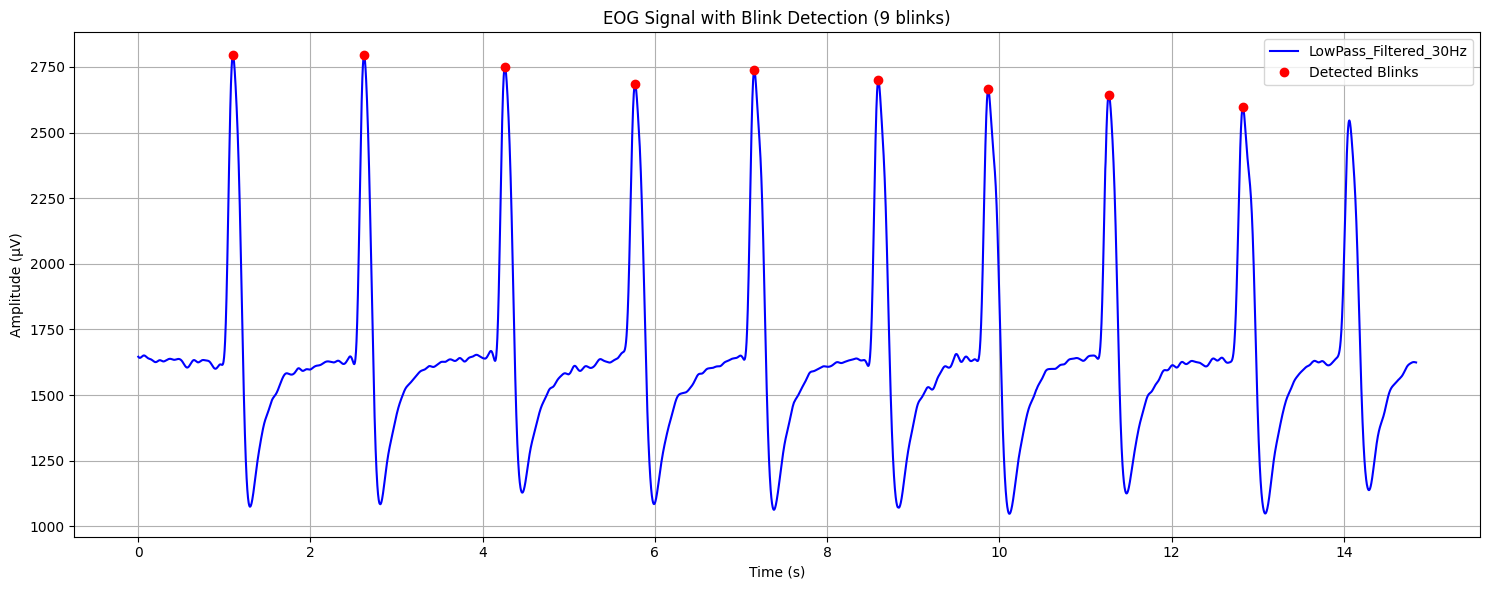

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Load the EOG data from CSV
eog_data = pd.read_csv('csv//eog_data.csv')

# Extract the relevant columns
time_axis = eog_data['Time (s)'].values
eog_filtered = eog_data['LowPass_Filtered_30Hz'].values
sampling_rate = 1 / np.mean(np.diff(time_axis))  # Calculate sampling rate from time differences

def detect_peaks(signal, threshold, sampling_rate):
    peaks = []
    prev_peak_time = None  # Variable to store the timestamp of the previous peak
    min_peak_gap = 0.1     # Minimum time gap between two peaks in seconds

    for i in range(1, len(signal) - 1):
        if signal[i] > signal[i - 1] and signal[i] > signal[i + 1] and signal[i] > threshold:
            current_peak_time = i / sampling_rate  # Time in seconds based on the sampling rate

            if prev_peak_time is not None:
                time_gap = current_peak_time - prev_peak_time
                if time_gap < min_peak_gap:
                    continue

            peaks.append(i)
            prev_peak_time = current_peak_time

    return peaks

def detect_blinks(filtered_eog, sampling_rate):
    blink_indices = []
    window_size = int(1 * sampling_rate)  # 1-second window
    
    # Process the signal in 1-second windows
    for current_index in range(window_size, len(filtered_eog), window_size):
        start_index = current_index - window_size
        end_index = current_index
        
        # Get the current window
        filtered_window = filtered_eog[start_index:end_index]
        
        # Calculate dynamic threshold
        mean_signal = np.mean(filtered_window)
        stdev_signal = np.std(filtered_window)
        threshold = mean_signal + (2 * stdev_signal)
        
        # Detect peaks in this window
        peaks = detect_peaks(filtered_window, threshold, sampling_rate)
        
        # Convert to absolute indices and store
        for peak in peaks:
            full_peak_index = start_index + peak
            blink_indices.append(full_peak_index)
    
    return np.array(blink_indices)

# Detect blinks using the specified method
blink_indices = detect_blinks(eog_filtered, sampling_rate)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(time_axis, eog_filtered, 'b-', label='LowPass_Filtered_30Hz')
if len(blink_indices) > 0:  # Only plot if we found blinks
    plt.plot(time_axis[blink_indices], eog_filtered[blink_indices], 'ro', label='Detected Blinks')
plt.title(f'EOG Signal with Blink Detection ({len(blink_indices)} blinks)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
# Send STOP command to terminate data acquisition
client.send_command('STOP')
print("Streaming stopped")

Streaming stopped


#### Summary & Key Takeaways

- EOG Basics: Electrooculography measures the corneo-retinal standing potential between the front and back of the eye.

- Signal Quality: Proper electrode placement and skin preparation are crucial for clean signals.

- Filtering: Notch and low-pass filters effectively remove noise and interference.

- Blink Detection: provides reliable methods for blink detection in EOG signals.

### Quick Troubleshooting Guide

⚠️ **Problem: No Signal?**
🔧 **Fix:** Check USB/wireless connection and ensure electrodes are properly attached.

⚠️ **Problem: Too Noisy?**
🔧 **Fix:** Move away from electrical appliances, and unplug the laptop charger.

For more information checkout [guide section](https://docs.upsidedownlabs.tech/guides/troubleshoot/tips/index.html) on documentation site.

#### Further Exploration

- Try with different duration (Eg- for 30 seconds)
- Detect different types of eye movements patterns (vertical vs horizontal)
- Try implementing real-time blink control applications
- Try implementing saccade detection